## Movielens

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

Data available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [2]:
#path='data/ml-latest-small/'
path='data/ml-latest/'

We're working with the movielens data, which contains one rating per row, like this:

In [3]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


Just for display purposes, let's read in the movie names too.

In [4]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [5]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,1196,1198,1210,2571,2959
userId,,,,,,,,,,,,,,,
8659,4.0,5.0,4.0,4.5,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0
24025,3.0,4.0,2.5,5.0,4.5,3.5,4.5,5.0,4.5,4.0,1.5,4.5,2.0,4.5,4.5
45811,4.0,3.5,4.0,4.5,4.5,3.5,4.0,4.5,4.0,4.0,4.0,4.0,4.0,4.0,3.5
70648,4.0,4.0,4.0,4.5,4.0,3.5,4.0,4.0,4.0,4.5,4.0,4.0,4.0,4.0,4.5
98415,3.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.5,2.5,4.0,3.0,4.0,2.0
98787,4.0,4.0,3.0,5.0,5.0,2.0,2.5,3.5,5.0,4.0,5.0,5.0,3.0,4.0,1.0
107720,3.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0,5.0,4.0
172224,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0
179792,5.0,4.0,5.0,5.0,4.5,4.5,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0


In [6]:
mtitles = movies['title']; mtitles
#mtitles[topMovies[:20]]

rating
91921    NaN
91082    NaN
87901    NaN
84078    NaN
77960    NaN
77045    NaN
74355    NaN
67662    NaN
66512    NaN
66008    NaN
62714    NaN
61836    NaN
61672    NaN
60024    NaN
59693    NaN
Name: title, dtype: object

## Collaborative filtering

In [7]:
val_idxs = get_cv_idxs(len(ratings))
wd=2e-4   # Weight decay
n_factors = 50  # size of embedding matrix

In [8]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [9]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2, use_wd_sched=True)

A Jupyter Widget

[ 0.       1.75778  1.7247 ]                                        
 54%|█████▍    | 175217/325304 [26:55<23:03, 108.48it/s, loss=1.03] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 85%|████████▍ | 275974/325304 [41:07<07:21, 111.83it/s, loss=0.915]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 87%|████████▋ | 284232/325304 [42:17<06:06, 112.01it/s, loss=0.949]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 90%|████████▉ | 292464/325304 [43:27<04:52, 112.16it/s, loss=0.951]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 92%|█████████▏| 300732/325304 [44:38<03:38, 112.29it/s, loss=0.922]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 95%|█████████▍| 309000/325304 [45:48<02:25, 112.43it/s, loss=0.947]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 98%|█████████▊| 317316/325304 [46:59<01:10, 112.56it/s, loss=0.974]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[ 1.       0.92436  0.93086]                                        
[ 2.       1.69371  1.73627]                                        



Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We'll need to take the square root of our loss, since we use plain MSE.

In [10]:
math.sqrt(0.82999)

0.9110378696848995

Looking good - we've found a solution better than any of those benchmarks! Let's take a look at how the predictions compare to actuals for this model.

In [11]:
preds = learn.predict()

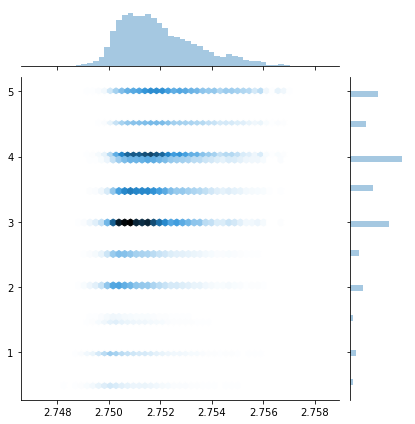

In [12]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

## 4. Analyze results

### Movie bias

In [13]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

In [14]:
m=learn.model; m.cuda()

EmbeddingDotBias(
  (u): Embedding(270896, 50)
  (i): Embedding(45115, 50)
  (ub): Embedding(270896, 1)
  (ib): Embedding(45115, 1)
)

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [15]:
movie_bias = to_np(m.ib(V(topMovieIdx)))

In [16]:
movie_bias

array([[ 0.00515],
       [ 0.00586],
       [ 0.0051 ],
       ..., 
       [ 0.0005 ],
       [ 0.00003],
       [ 0.00046]], dtype=float32)

In [17]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [18]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.001095693, 'Speed 2: Cruise Control (1997)'),
 (-0.0010781257, 'Batman & Robin (1997)'),
 (-0.0010576929, 'Battlefield Earth (2000)'),
 (-0.00097094313, 'Anaconda (1997)'),
 (-0.00086085196, 'Super Mario Bros. (1993)'),
 (-0.00083706144, 'Grease 2 (1982)'),
 (-0.00083568972, 'Wild Wild West (1999)'),
 (-0.00078341545, 'Godzilla (1998)'),
 (-0.00077123265, 'Showgirls (1995)'),
 (-0.00076909078, 'I Still Know What You Did Last Summer (1998)'),
 (-0.00076816347, 'Flintstones, The (1994)'),
 (-0.00075990951, 'Home Alone 3 (1997)'),
 (-0.00074667967, 'Howard the Duck (1986)'),
 (-0.00073303946, 'Barb Wire (1996)'),
 (-0.00071856467, 'Spice World (1997)')]

In [19]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.001095693, 'Speed 2: Cruise Control (1997)'),
 (-0.0010781257, 'Batman & Robin (1997)'),
 (-0.0010576929, 'Battlefield Earth (2000)'),
 (-0.00097094313, 'Anaconda (1997)'),
 (-0.00086085196, 'Super Mario Bros. (1993)'),
 (-0.00083706144, 'Grease 2 (1982)'),
 (-0.00083568972, 'Wild Wild West (1999)'),
 (-0.00078341545, 'Godzilla (1998)'),
 (-0.00077123265, 'Showgirls (1995)'),
 (-0.00076909078, 'I Still Know What You Did Last Summer (1998)'),
 (-0.00076816347, 'Flintstones, The (1994)'),
 (-0.00075990951, 'Home Alone 3 (1997)'),
 (-0.00074667967, 'Howard the Duck (1986)'),
 (-0.00073303946, 'Barb Wire (1996)'),
 (-0.00071856467, 'Spice World (1997)')]

In [20]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(0.005861192, 'Shawshank Redemption, The (1994)'),
 (0.0052097668, 'Silence of the Lambs, The (1991)'),
 (0.0051539005, 'Forrest Gump (1994)'),
 (0.0051030391, 'Pulp Fiction (1994)'),
 (0.0048872121, 'Matrix, The (1999)'),
 (0.0048522707, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.0047398545, "Schindler's List (1993)"),
 (0.0046721562, 'Usual Suspects, The (1995)'),
 (0.0045565446, 'Godfather, The (1972)'),
 (0.0045172488, 'Fight Club (1999)'),
 (0.0044663544,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (0.0044353311, 'Braveheart (1995)'),
 (0.0044314144, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.0043671187, 'American Beauty (1999)'),
 (0.0042933151, 'Toy Story (1995)')]

### Embedding interpretation

We can now do the same thing for the embeddings.

In [21]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [23]:
movie_pca.shape

(3, 3000)

In [24]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'easy watching' vs 'serious'.

In [25]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.017043173, 'Batman & Robin (1997)'),
 (0.015875027, 'Speed 2: Cruise Control (1997)'),
 (0.014002944, 'Battlefield Earth (2000)'),
 (0.012459123, 'Grease 2 (1982)'),
 (0.012207969, 'Super Mario Bros. (1993)'),
 (0.012087335, 'Wild Wild West (1999)'),
 (0.011903509, 'Barb Wire (1996)'),
 (0.011786534, 'Anaconda (1997)'),
 (0.011131025, 'Next Karate Kid, The (1994)'),
 (0.011091341, 'Inspector Gadget (1999)')]

In [26]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.074488014, 'Shawshank Redemption, The (1994)'),
 (-0.068598345, 'Pulp Fiction (1994)'),
 (-0.068492398, 'Silence of the Lambs, The (1991)'),
 (-0.067463636, 'Forrest Gump (1994)'),
 (-0.066937633, 'Star Wars: Episode IV - A New Hope (1977)'),
 (-0.065863676, 'Matrix, The (1999)'),
 (-0.062959932, "Schindler's List (1993)"),
 (-0.062883034,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (-0.062231153, 'Usual Suspects, The (1995)'),
 (-0.06190832, 'Star Wars: Episode V - The Empire Strikes Back (1980)')]

In [27]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component. It seems to be 'CGI' vs 'dialog driven'.

In [28]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.086281545, 'Net, The (1995)'),
 (0.074767686, 'Batman Forever (1995)'),
 (0.073918015, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.072297297, 'Armageddon (1998)'),
 (0.070945717, 'Twister (1996)'),
 (0.068482965, 'Eraser (1996)'),
 (0.068275318, 'Specialist, The (1994)'),
 (0.067890435, 'Judge Dredd (1995)'),
 (0.067369953, 'Under Siege 2: Dark Territory (1995)'),
 (0.065828182, 'Species (1995)')]

In [29]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.037033942, '8 1/2 (8½) (1963)'),
 (-0.034176927, 'Raging Bull (1980)'),
 (-0.034006003, 'Vertigo (1958)'),
 (-0.033525418, 'Third Man, The (1949)'),
 (-0.033349101, 'Maltese Falcon, The (1941)'),
 (-0.033256251, 'M (1931)'),
 (-0.032619543, 'Casablanca (1942)'),
 (-0.032171384, 'Rear Window (1954)'),
 (-0.031630948, 'Citizen Kane (1941)'),
 (-0.030838633, 'Touch of Evil (1958)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

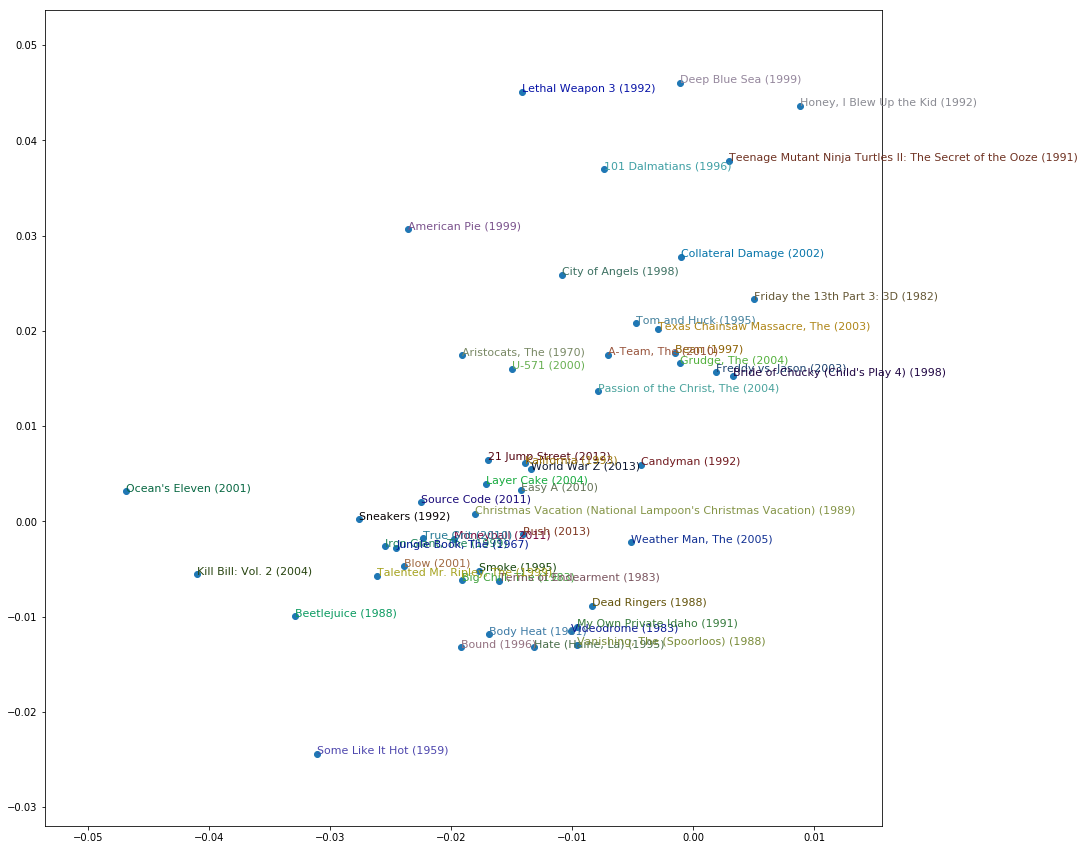

In [30]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collab filtering from scratch

### Dot product example

In [31]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

(
  1  2
  3  4
 [torch.FloatTensor of size 2x2], 
   2   2
  10  10
 [torch.FloatTensor of size 2x2])

In [32]:
a*b


  2   4
 30  40
[torch.FloatTensor of size 2x2]

In [33]:
(a*b).sum(1)


  6
 70
[torch.FloatTensor of size 2]

In [34]:
class DotProduct(nn.Module):
    def forward(self, u, m): return (u*m).sum(1)

In [35]:
model=DotProduct()

In [36]:
model(a,b)


  6
 70
[torch.FloatTensor of size 2]

### Dot product model

In [37]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [38]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(movies)
        return (u*m).sum(1)

In [39]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [40]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [41]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [42]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       1.3383   1.32907]                                       
[ 1.       1.30148  1.29654]                                       
[ 2.       1.27836  1.28706]                                       



In [43]:
set_lrs(opt, 0.01)

In [44]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.98944  1.00221]                                        
[ 1.       0.95604  0.99421]                                        
[ 2.       0.9504   0.99233]                                        



### Bias

In [45]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

In [46]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1)
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze()
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        return res

In [47]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [48]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.96059  0.96961]                                        
[ 1.       0.98297  0.96892]                                        
[ 2.       0.96652  0.96918]                                        



In [49]:
set_lrs(opt, 1e-2)

In [50]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.94903  0.95747]                                        
[ 1.       0.94798  0.95753]                                        
[ 2.       0.92898  0.95759]                                        



### Mini net

nn.Linear already includes a bias

In [51]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [52]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [53]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.88566  0.83494]                                        
 97%|█████████▋| 314163/325304 [47:11<01:40, 110.95it/s, loss=0.874]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[ 1.       0.93639  0.83777]                                        
[ 2.       0.87424  0.83404]                                        



In [54]:
set_lrs(opt, 1e-3)

In [55]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.88866  0.8327 ]                                        
[ 1.       0.86579  0.83405]                                        
[ 2.       0.89526  0.83477]                                        

